# **Approche supervisée**

<div class="alert alert-info">
Lors de l'approche non supervisée, la plus haute proportion de tags correctement prédits (au moins un tag réel prédit) obtenue était de 12.90 %, en gardant en tête que le maximum possible était de 34.92 % (cas où les tags réels sont présents dans le texte du document), puisque ces approches non supervisées sont uniquement basées sur le texte des documents. Nous allons avoir s'il est possible d'améliorer ces résultats avec une approche supervisée.
</div>

In [1]:
# Éviter les Warnings
import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Pour manipuler nos données
import pandas as pd

# Utilisé dans plusieurs fonctions de préparation des données
import numpy as np

# Pour les vectorisations de type bag of words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Gensim - Pour la vectorisation de type Word2Vec
from gensim.models import Word2Vec

# Utilisé pour l'embedding avec Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Model

# Utilisé pour l'embedding avec BERT (Hugging Face)
from transformers import TFAutoModel
from transformers import AutoTokenizer

# Utilisé pour l'embedding avec USE
import tensorflow_hub as hub

# Pour réduction dimentionnelle des features
from sklearn.decomposition import PCA

# Modèles supervisés
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier  # Utilisé avec LinearSVC et LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Visualisations
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Mesures de performance des prédictions
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss

# Utilisé dans la fonction de qualité des prédictions
# et pour encoder les tags avant de les passer dans les modèles
from sklearn.preprocessing import MultiLabelBinarizer

# Pour segmenter nos données train/test
from sklearn.model_selection import train_test_split

# Pour rendre les résultats reproductibles (le plus possible)
from tensorflow.keras.utils import set_random_seed

# Mesures de durée d'éxécution
# Aussi utilisé dans run_and_eval_model
import time

# Utilisé lors des sauvagardes et chargement de données/objets
import pickle
import os  # Aussi utilisé pour connaitre le nombre de CPU

# Pour loger les run des modèles
import mlflow
import mlflow.sklearn

Ce notebook fonctionne avec : 

- Python 3.10.9
- Anaconda 23.3.1
- Wordcloud 1.9.2
- Gensim 4.3.0
- Tensorflow 2.10.1
- setuptools 68.2.2
- mlflow 2.7.1

- Mesure de la durée d'exécution du notebook : 

In [2]:
t_notebook = time.time()

- Set d'une seed commune pour des résultats reproductibles, ou pour s'en approcher car le multithreading peut amener un peu de variabilité.

In [3]:
seed_value = 42
set_random_seed(seed_value)  # Définit une seed commune pour random, numpy et tensorflow

- Nombre de threads disponibles

In [4]:
# workers_to_use pourra être utilisé pour les algorithmes qui gèrent le multithreading
workers_to_use = os.cpu_count() - 1  # J'en retire 1 pour plus de stabilité

- Paramètres pour ML Flow

In [5]:
# Log des exécutions des modèles supervisés
# hyperparamètres et métriques
do_log_run = False

# Enregistrement du modèle entraîné
# si le log des exécutions est activé
save_model = False

## **1). Importations des données**

In [6]:
with open('data_clean.pkl', 'rb') as fichier:
    data = pickle.load(fichier)

data

,date,corpus,corpus_dl,tags
0,2022-05-08 21:22:05,"[firebase, testing, jest, error, assertion, cl...","[firebase, testing, with, jest, throws, error,...","[firebase, jestjs, reactjs]"
1,2022-05-08 21:49:08,"[block, hack, language, benefit, block, job, w...","[concurrent, block, in, hacklang, since, hack,...","[async-await, concurrency]"
2,2022-05-08 21:49:57,"[type, function, typescript, function, type, i...","[can, you, set, a, type, for, a, function, in,...",[typescript]
3,2022-05-08 21:51:00,"[store, service, account, looking, expo, appli...","[expo, eas, submit, where, to, store, service,...",[expo]
4,2022-05-08 22:32:53,"[store, retrieve, structure, type, c, copying,...","[reliably, and, portably, store, and, retrieve...",[c]
...,...,...,...,...
46493,2022-03-21 08:52:43,"[option, option, know, option, case, option, o...","[how, to, know, if, a, select2, has, options, ...","[javascript, jquery]"
46494,2022-03-21 08:54:03,"[ring, plot, attempt, gap, use, plot, paint, r...","[matplotlib, how, to, plot, a, closed, ring, i...","[matplotlib, python]"
46495,2022-03-21 09:02:54,"[security, problem, terraform, dependency, loc...","[which, security, problem, does, terraform, ch...",[terraform]
46496,2022-03-21 13:54:21,"[studio, creation, blob, container, error, mes...","[visual, studio, 2022, with, azurite, integrat...",[azure]


### **Option d'échantillonages pour la réalisation de tests**

In [7]:
echantillon = False
taille_echantillon = 15000

if echantillon:
    data = data.sample(taille_echantillon, random_state=seed_value)  # random_state car en fonction de l'échantillonage
                                                                     # les résultats peuvent changer et pour pouvoir
                                                                     # comparer nos tunings d'hyperparamètres, nous devons
                                                                     # avoir des résultats reproductibles

    data
else:
    print("Pas d'échantillonnage.")

Pas d'échantillonnage.


## **2). Vectorisations du corpus de type <i>Bag Of Words</i>**

### **A). Vectorisations de type <i>bag-of-words</i> classique**

Nous utilisons *data['corpus']*, le corpus avec traitement complet (suppression des stopwords, des mots rares, etc).

In [8]:
# Chaque document de data['corpus'] est sous la forme d'une liste de mot.
# CountVectorizer() prend en entrée un string. Nous allons donc concaténer chaque document.
preprocessed_corpus = [' '.join(doc) for doc in data['corpus']]

# max_features : ne retenir que les x mots les plus fréquents
# Sans cette limite, le nombre de features serait égal
# au nombre de mots dans le vocabulaire
max_features = 500

# Création de CountVectorizer et vectorisation des données textuelles
vectorizer_count = CountVectorizer(max_features=max_features)
vectorized_corpus_count = vectorizer_count.fit_transform(preprocessed_corpus)

# Afficher les caractéristiques de la matrice vectorisée
print(f"Nombre d'observations (documents) : {vectorized_corpus_count.shape[0]}")
print(f"Nombre de variables (features) : {vectorized_corpus_count.shape[1]}")
print("Premier document vectorisé (100 premières features) :")
print(vectorized_corpus_count.toarray()[0][:100])

Nombre d'observations (documents) : 46498
Nombre de variables (features) : 500
Premier document vectorisé (100 premières features) :
[0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


- Réduction dimentionnelle de la vectorisation *bag-of-words* classique, qui comporte 500 features, à l'aide d'une ACP.

In [9]:
pca_bow = PCA(n_components=300)
vectorized_corpus_count_reduced = pca_bow.fit_transform(vectorized_corpus_count.toarray())  # .toarray() car vectorized_corpus_count
                                                                                        # est une matrice creuse qui ne peut pas
                                                                                        # être traitée telle quelle pour l'ACP

# Pourcentage d'inertie expliqué par chaque composante
explained_variance_ratio = pca_bow.explained_variance_ratio_

# Pourcentage cumulatif d'inertie expliqué
cumulative_explained_variance_ratio = explained_variance_ratio.cumsum()

print(f"Pourcentage cumulatif d'inertie expliqué : {cumulative_explained_variance_ratio[-1]*100:.2f}%")

Pourcentage cumulatif d'inertie expliqué : 91.03%


### **B). Vectorisations de type <i>bag-of-words</i> TF-IDF**

Nous utilisons encore *data['corpus']*, le corpus avec traitement complet (suppression des stopwords, des mots rares, etc).

In [10]:
# max_features : ne retenir que les x mots les plus fréquents
# Sans cette limite, le nombre de features serait égal
# au nombre de mots dans le vocabulaire
max_features = 500

# Création de TfidfVectorizer et vectorisation des données textuelles
vectorizer_tfidf = TfidfVectorizer(max_features=max_features)
vectorized_corpus_ftidf = vectorizer_tfidf.fit_transform(preprocessed_corpus)  # On réutilise preprocessed_corpus crée lors
                                                                               # de la vectorisation BoW classique

# Afficher les caractéristiques de la matrice vectorisée
print(f"Nombre d'observations (documents) : {vectorized_corpus_ftidf.shape[0]}")
print(f"Nombre de variables (features) : {vectorized_corpus_ftidf.shape[1]}")
print("Premier document vectorisé (100 premières features) :")
print(vectorized_corpus_ftidf.toarray()[0][:100])

Nombre d'observations (documents) : 46498
Nombre de variables (features) : 500
Premier document vectorisé (100 premières features) :
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.20109768
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.16017539 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.09734    0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.11521863
 0.         0.         0.

- Réduction dimentionnelle de la vectorisation *bag-of-words* TF-IDF, qui comporte 500 features, à l'aide d'une ACP. Ici, nous devrons garder 400 features pour conserver plus de 90% de l'inertie, la réduction n'est donc pas très efficace.

In [11]:
pca_tfidf = PCA(n_components=400)
vectorized_corpus_ftidf_reduced = pca_tfidf.fit_transform(vectorized_corpus_ftidf.toarray())  # .toarray() car vectorized_corpus_ftidf
                                                                                        # est une matrice creuse qui ne peut pas
                                                                                        # être traitée telle quelle pour l'ACP

# Pourcentage d'inertie expliqué par chaque composante
explained_variance_ratio = pca_tfidf.explained_variance_ratio_

# Pourcentage cumulatif d'inertie expliqué
cumulative_explained_variance_ratio = explained_variance_ratio.cumsum()

print(f"Pourcentage cumulatif d'inertie expliqué : {cumulative_explained_variance_ratio[-1]*100:.2f}%")

Pourcentage cumulatif d'inertie expliqué : 93.27%


## **3). Vectorisations de type <i>Word/Sentence Embedding</i>**

### **A). Word2Vec**

Nous utilisons de nouveau *data['corpus']*, le corpus avec traitement complet (suppression des stopwords, des mots rares, etc).

Avant de démarrer, regardons les tailles des documents de notre corpus avec traitement complet (data['corpus']), ceci va nous servir par la suite : 

In [12]:
min_length = min(len(document) for document in data['corpus'])

# Afficher la taille de la plus grande liste
print(f"La taille du plus court document est : {min_length}")

max_length = max(len(document) for document in data['corpus'])

# Afficher la taille de la plus grande liste
print(f"La taille du plus long document est : {max_length}")

# Calculer la taille moyenne
average_length = sum(len(document) for document in data['corpus']) / len(data['corpus'])

# Afficher la taille moyenne
print(f"La taille moyenne des documents est : {average_length:.1f}")

# Afficher Q3 (75e percentile)
q3_length = np.percentile([len(document) for document in data['corpus']], 75)
print(f"75% des documents ont une longueur <= à {q3_length} mots.")

La taille du plus court document est : 1
La taille du plus long document est : 846
La taille moyenne des documents est : 26.3
75% des documents ont une longueur <= à 32.0 mots.


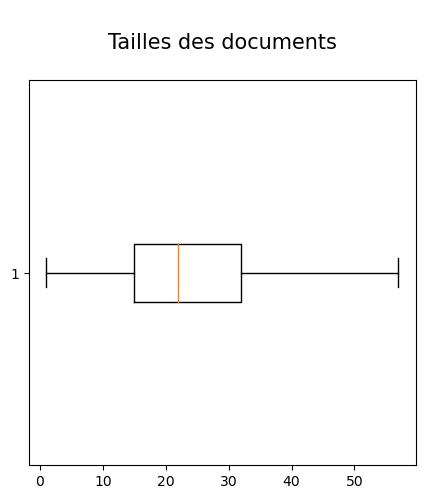

In [13]:
plt.figure(figsize=(5, 5))
plt.boxplot([len(document) for document in data['corpus']], vert=False, showfliers=False)
plt.title(f"\nTailles des documents\n", fontsize=15)
plt.show()

- Choix entre CBOW et Skip-gram à utiliser dans Word2Vec.

**CBOW (Continuous Bag of Words) :** vise à prédire un mot étant donné son contexte, c'est-à-dire étant donné les mots qui en sont proches dans le texte. S'entraîne plus rapidement que Skip-Gram (mieux adapté pour des dataset volumineux) et peut mieux représenter les mots plus fréquents.

**Skip-gram :** architecture symétrique visant à prédire les mots du contexte étant donné un mot en entrée. Fonctionne bien avec de petits datsets et peut mieux représenter les mots moins fréquents.

Dans notre cas, notamment en raison de la taille du dataset, nous utiliserons **CBOW**.

- Création et entraînement du modèle Word2Vec

In [14]:
# Paramètres à passer dans le modèle : 

w2v_size = 100  # Taille max des vecteurs
w2v_window = 5  # Taille du contexte
w2v_min_count = 1  # Minimum d'occurences d'un mot pour être pris en compte
w2v_epochs = 50  # Nombre de passes sur tout le corpus

documents = data['corpus']

############################
# Enregistrement du modèle #
############################

nom_fichier_w2v = 'w2v_model_trained'

# Si le modèle (entraîné) avait été enregistré, charger ce dernier.
if os.path.isfile(f'{nom_fichier_w2v}.pkl') == True and not echantillon:  # Seulement quand on travaille avec le dataset complet
    print(f"Un modèle entraîné précédemment enregistré a été trouvé, chargement de ce dernier.\nSi vous souhaitez réentraîner le modèle, supprimez le fichier {nom_fichier_w2v}.pkl")
    with open(f'{nom_fichier_w2v}.pkl', 'rb') as fichier:
        w2v_model = pickle.load(fichier)
# Sinon, entraîner le modèle et l'enregistrer
else:
    # Création et entraînement du modèle Word2Vec

    print("Création et entraînement du modèle Word2Vec...")
    w2v_model = Word2Vec(min_count=w2v_min_count,
                        window=w2v_window,
                        vector_size=w2v_size,
                        sg=0,  # 0 : CBOX, 1 : Skipgram
                        seed=seed_value,  # Paramétrage de la seed pour des résultats plus reproductibles
                        workers= 1 # Pour du multithreading pour accélérer les calculs, utiliser workers_to_use.
                                   # Mais attention, utiliser plusieurs threads amène une légère variabilité
                                   # en raison des variations de l'ordonnancement des threads du
                                   # système d'exploitation. Pour des résultats parfaitement reproductibles,
                                   # utiliser un seul worker.
    )

    w2v_model.build_vocab(documents)

    w2v_model.train(documents,
                    total_examples=w2v_model.corpus_count,
                    epochs=w2v_epochs
    )
    
    print("Word2Vec entraîné")
    
    # Enregistrement du modèle entraîné
    if not echantillon:  # On sauvegarde seulement quand on travaille avec le dataset complet
        with open(f'{nom_fichier_w2v}.pkl', 'wb') as fichier:
            pickle.dump(w2v_model, fichier)
        print(f"Modèle entraîné enregistré dans le fichier {nom_fichier_w2v}.pkl")


model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Taille du vocabulaire : %i" % len(w2v_words))

Un modèle entraîné précédemment enregistré a été trouvé, chargement de ce dernier.
Si vous souhaitez réentraîner le modèle, supprimez le fichier w2v_model_trained.pkl
Taille du vocabulaire : 3707


- Test du modèle entraîné pour vérifier qu'il a réussi à capter les similarités entre les mots

In [15]:
# Mots similaires à un mot donné
mot_a_tester = "python"
print(f"Mots similaires à '{mot_a_tester}' :\n")
similar_words = w2v_model.wv.most_similar(positive=[mot_a_tester])
for word, similarity in similar_words:
    print(f"{word} : {similarity:.4f}")

print("\n--------------------\n")

# Similarité entre deux mots
mot_a_tester_1 = "python"
mot_a_tester_2 = "virtualenv"
similarite = w2v_model.wv.similarity(mot_a_tester_1, mot_a_tester_2)
print(f"Similarité entre '{mot_a_tester_1}' et '{mot_a_tester_2}' : {similarite:.4f}")

print("\n--------------------\n")

# Trouver l'intrus
mot_intrus_1 = "python"
mot_intrus_2 = "javascript"
mot_intrus_3 = "image"
intrus = w2v_model.wv.doesnt_match([mot_intrus_1, mot_intrus_2, mot_intrus_3])
print(f"L'intrus parmi ces mots ['{mot_intrus_1}', '{mot_intrus_2}', '{mot_intrus_3}'] est : '{intrus}'.")

Mots similaires à 'python' :

pip : 0.4790
pyenv : 0.4386
modulenotfounderror : 0.4354
r : 0.4190
poetry : 0.4116
interpreter : 0.4012
pypi : 0.3976
setuptool : 0.3963
pycharm : 0.3945
online : 0.3943

--------------------

Similarité entre 'python' et 'virtualenv' : 0.3835

--------------------

L'intrus parmi ces mots ['python', 'javascript', 'image'] est : 'image'.


<div class="alert alert-info">
Cela semble assez cohérent. Le modèle semble avoir réussi à capter les similarités entre les mots.
</div>

- Préparation des documents (tokenization)

In [16]:
maxlen = 100  # Cette valeur apporte de meilleurs résultat que
              # int(q3_length) : valeur du 75e percentile des tailles des documents (calculé précédemment)
              # int(average_length) : taille moyenne des documents (calculé précédemment)

# On réutilise documents (défini lors de la création et entraînement du modèle Word2Vec),
# documents contient data['corpus']
print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(documents)
x_documents = pad_sequences(tokenizer.texts_to_sequences(documents),
                            maxlen=maxlen,  # On ne prend que les maxlen premiers mots de chaque document
                            padding='post'  # Si le document est plus petit que maxlen, on complète avec des 0
) 
                                                   
num_words = len(tokenizer.word_index) + 1  # + 1 : on ajoute 1 pour inclure un index supplémentaire.
                                           # Cet index supplémentaire est ajouté pour tenir compte des mots inconnus
                                           # qui n'apparaissent pas dans le jeu de données d'entraînement initial.
                                           
print("Nombre de mots uniques : %i" % num_words)
print("Premier document encodé :")
print(x_documents[0])

Fit Tokenizer ...
Nombre de mots uniques : 3708
Premier document encodé :
[ 245  290 1561    2  935   13  222  290   27   11  245   36   39  161
   40  245    2   36 1627  245  167    3  245   66   27  313  463    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


- Création de la matrice d'embedding

In [17]:
print("Création de la matrice d'embedding...")

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # + 1 pour les même raisons que précédemment.
embedding_matrix = np.zeros((vocab_size, w2v_size))  # w2v_size a été déterminé à la création et
                                                     # entraînement du modèle Word2Vec, pour représenter
                                                     # la taille max des vecteurs. La matrice qu'on crée ici
                                                     # doit avoir la même "largeur".

i=0
j=0   
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)  # Taux d'intégration de mots : Ce taux indique la proportion de mots du corpus
                             # pour lesquels un vecteur d'embedding a été trouvé dans le modèle Word2Vec.
                             # Un taux élevé suggère que la plupart des mots du corpus ont été trouvés dans
                             # le modèle Word2Vec, ce qui signifie que la couverture du modèle d'embedding
                             # est suffisamment large pour représenter le vocabulaire du corpus. 

print("Taux d'intégration de mots :", word_rate)
print(f"Dimensions de la matrice d'embedding : {embedding_matrix.shape}")

Création de la matrice d'embedding...
Taux d'intégration de mots : 1.0
Dimensions de la matrice d'embedding : (3708, 100)


Le taux d'intégration de mots est bon, la couverture du modèle d'embedding est suffisamment large pour représenter le vocabulaire du corpus.<br>
En fixant *w2v_min_count* à 1 (minimum d'occurences d'un mot pour être pris en compte) lors de l'étape d'entraînement du modèle Word2Vec, on s'attend à un taux d'intégration de mots maximal.

- Création du modèle d'embedding

In [18]:
# Création du modèle

input = Input(shape=(len(x_documents), maxlen),  # On réutilise le même maxlen
                                                 # que celui défini lors de la préparation
                                                 # des documents (tokenization)
            dtype='float64'
)

word_input = Input(shape=(maxlen,),dtype='float64')

word_embedding = Embedding(input_dim=vocab_size,
                           output_dim=w2v_size,
                           weights = [embedding_matrix],
                           input_length=maxlen)(word_input)

word_vec=GlobalAveragePooling1D()(word_embedding)

embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 100)          370800    
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 370,800
Trainable params: 370,800
Non-trainable params: 0
_________________________________________________________________


- Exécution du modèle

In [19]:
word2vec_embedded = embed_model.predict(x_documents, verbose=0)
print(f"Dimensions de 'word2vec_embedded' : {word2vec_embedded.shape}")
print("Premier document encodé :")
print(word2vec_embedded[0])

Dimensions de 'word2vec_embedded' : (46498, 100)
Premier document encodé :
[ 0.00969069  0.01321123 -0.04480806  0.01788921  0.05010077 -0.03574872
  0.28900322  0.2242672  -0.14532755  0.13428308  0.2096692   0.06750458
 -0.24592896 -0.1534113  -0.17026216 -0.01465662 -0.08112413  0.24050009
 -0.00063547  0.02759812  0.3631919  -0.00303705 -0.2189009  -0.10132784
  0.01524056  0.09774195 -0.03866203 -0.1955285   0.11311232 -0.13304017
  0.07220504 -0.29820132  0.01475078  0.03793701  0.00285432 -0.07667759
 -0.16699784 -0.16624227  0.01130853 -0.02775044 -0.09789311 -0.06757158
 -0.34855935 -0.02401404  0.03611669  0.14539246  0.05993536  0.11015394
  0.00735351 -0.0581399   0.146653    0.11877933  0.36097878  0.2443562
  0.22058658  0.03172379  0.17728853 -0.11030269  0.04064707  0.06090025
  0.07208482  0.01733155 -0.06616202  0.14326526  0.05387218  0.19548507
  0.01357756  0.043      -0.11071533 -0.21463135  0.04357689 -0.08674095
 -0.04625629  0.0280135   0.22280087  0.04288813  

### **B). BERT (Bidirectional Encoder Representations from Transformers - Version de HuggingFace)**

- Nous utilisons *data['corpus_dl']*, le corpus avec traitement minimal (uniquement suppression des balises HTML, du code, de la ponctuation et passage en minuscules).
- Nous utiliserons le modèle préentraîné *bert-base-uncased*

- Fonction de préparation des documents

In [20]:
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot

- Fonction de création des features

In [21]:
def feature_BERT_fct(model, model_type, sentences, max_length, b_size):
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()
    last_hidden_states_tot = None

    for step in range(0, len(sentences), batch_size):
        batch_sentences = sentences[step:step + batch_size]
        if not batch_sentences:  # Vérifier si la liste est vide
            continue
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(batch_sentences, bert_tokenizer, max_length)
        
        outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
        last_hidden_states = outputs.last_hidden_state
                    
        if last_hidden_states_tot is None:
            last_hidden_states_tot = last_hidden_states
        else:
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot, last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    time2 = np.round(time.time() - time1, 0)
    print(f"Durée du traitement : {time2} s.")
     
    return features_bert, last_hidden_states_tot

- Création des features

In [22]:
##################################################
# Enregistrement du corpus vectorisé avec BERT   #
# Car il est très long à produire (env 130 min)  #
##################################################

nom_fichier_corpus_bert = 'corpus_BERT_base'

# Si le corpus (vectorisé avec BERT) avait été enregistré, charger ce dernier.
if os.path.isfile(f'{nom_fichier_corpus_bert}.pkl') == True and not echantillon:  # Seulement quand on travaille avec le dataset complet
    print(f"Un corpus vectorisé précédemment enregistré a été trouvé, chargement de ce dernier.\nSi vous souhaitez en produire un nouveau, supprimez le fichier {nom_fichier_corpus_bert}.pkl")
    with open(f'{nom_fichier_corpus_bert}.pkl', 'rb') as fichier:
        features_bert = pickle.load(fichier)
# Sinon, production du corpus vectorisé avec le modèle BERT et l'enregistrer
else:
    documents_dl = [' '.join(doc) for doc in data['corpus_dl']]  # Conversion des documents en un string unique
                                                                 # pour pouvoir être passé dans le modèle
    max_length = 64
    batch_size = 10
    model_type = 'bert-base-uncased'  # Utilisation du modèle BERT préentraîné classique
    model = TFAutoModel.from_pretrained(model_type)
    
    features_bert, last_hidden_states_tot = feature_BERT_fct(model,
                                                             model_type,
                                                             documents_dl, 
                                                             max_length,
                                                             batch_size
                                            )
    
    # Enregistrement du corpus vectorisé avec BERT
    if not echantillon:  # On sauvegarde seulement quand on travaille avec le dataset complet
        with open(f'{nom_fichier_corpus_bert}.pkl', 'wb') as fichier:
            pickle.dump(features_bert, fichier)
        print(f"Corpus vectorisé avec BERT enregistré dans le fichier {nom_fichier_corpus_bert}.pkl")

print(f"Dimensions de 'features_bert' : {features_bert.shape}")
print("Premier document encodé (100 premières features) :")
print(features_bert[0][:100])

Un corpus vectorisé précédemment enregistré a été trouvé, chargement de ce dernier.
Si vous souhaitez en produire un nouveau, supprimez le fichier corpus_BERT_base.pkl
Dimensions de 'features_bert' : (46498, 768)
Premier document encodé (100 premières features) :
[-0.02556176  0.19166619  0.13080832 -0.14533731  0.23192279 -0.23390609
  0.27231774  0.25221944  0.16529511 -0.12145934  0.0659398  -0.14643262
 -0.33279145  0.14341973 -0.15929255  0.00929002  0.2015008   0.08399679
  0.02982539  0.23026131  0.29575825 -0.05759588 -0.3690429   0.03308808
  0.44189963  0.01144834  0.239389   -0.15979534 -0.56839114 -0.13160312
  0.3315953   0.19866315  0.2921474  -0.19504544 -0.27311787  0.06223141
 -0.01483567 -0.11062288  0.02103019  0.24610347 -0.33306476 -0.54891557
  0.356569    0.01045101  0.07970545 -0.06478487  0.03056774  0.07713743
  0.06517577  0.16926381 -0.6254287   0.5211275  -0.08492912  0.08516291
  0.28313196  0.31063607  0.21442682 -0.78507257 -0.21066892 -0.28344142
  0.39

- Réduction dimentionnelle de la vectorisation BERT, qui comporte 768 features, à l'aide d'une ACP.

In [23]:
pca_bert = PCA(n_components=200)
features_bert_reduced = pca_bert.fit_transform(features_bert)

# Pourcentage d'inertie expliqué par chaque composante
explained_variance_ratio = pca_bert.explained_variance_ratio_

# Pourcentage cumulatif d'inertie expliqué
cumulative_explained_variance_ratio = explained_variance_ratio.cumsum()

print(f"Pourcentage cumulatif d'inertie expliqué : {cumulative_explained_variance_ratio[-1]*100:.2f}%")

Pourcentage cumulatif d'inertie expliqué : 92.00%


### **C). USE (Universal Sentence Encoder)**

- Fonction de création de features

In [24]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()
    remaining_sentences = len(sentences) % batch_size
    features = []

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step == 0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    # Ajout des lignes restantes si le nombre de documents
    # n'est pas un multiple de batch_size
    if remaining_sentences > 0:
        feat = embed(sentences[-remaining_sentences:])
        features = np.concatenate((features, feat))

    time2 = np.round(time.time() - time1,0)

    print(f"Durée du traitement : {time2} s.")

    return features

- Création des features

In [25]:
###############################################
# Enregistrement du corpus vectorisé avec USE #
# pour ne pas tout recalculer à chaque run    #
###############################################

nom_fichier_corpus_use = "corpus_USE"

# Si le corpus (vectorisé avec USE) avait été enregistré, charger ce dernier.
if os.path.isfile(f'{nom_fichier_corpus_use}.pkl') == True and not echantillon:  # Seulement quand on travaille avec le dataset complet
    print(f"Un corpus vectorisé précédemment enregistré a été trouvé, chargement de ce dernier.\nSi vous souhaitez en produire un nouveau, supprimez le fichier {nom_fichier_corpus_use}.pkl")
    with open(f'{nom_fichier_corpus_use}.pkl', 'rb') as fichier:
        features_USE = pickle.load(fichier)
# Sinon, production du corpus vectorisé avec le modèle USE et l'enregistrer
else:
    documents_dl = [' '.join(doc) for doc in data['corpus_dl']]  # Conversion des documents en un string unique
                                                                 # pour pouvoir être passé dans le modèle

    # Chargement du modèle préentraîné
    embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

    batch_size = 10

    features_USE = feature_USE_fct(documents_dl, batch_size)
    
    # Enregistrement du corpus vectorisé avec BERT
    if not echantillon:  # On sauvegarde seulement quand on travaille avec le dataset complet
        with open(f'{nom_fichier_corpus_use}.pkl', 'wb') as fichier:
            pickle.dump(features_USE, fichier)
        print(f"Corpus vectorisé avec USE enregistré dans le fichier {nom_fichier_corpus_use}.pkl")

print(f"Dimensions de 'features_USE' : {features_USE.shape}")
print("Premier document encodé (100 premières features) :")
print(features_USE[0][:100])

Un corpus vectorisé précédemment enregistré a été trouvé, chargement de ce dernier.
Si vous souhaitez en produire un nouveau, supprimez le fichier corpus_USE.pkl
Dimensions de 'features_USE' : (46498, 512)
Premier document encodé (100 premières features) :
[-0.04094313 -0.0475272  -0.03763066  0.0040827   0.02230911  0.03880174
  0.04704151  0.02561064  0.04544941  0.04325652  0.04316631 -0.06045892
  0.05608445  0.06192103 -0.06235017  0.0624683   0.04258667  0.02278395
  0.04786707  0.0266323   0.04511223  0.05755966 -0.06108991 -0.02969537
 -0.01397429  0.06109723  0.03212766 -0.02867802 -0.04171851 -0.05756116
 -0.03186219 -0.05645018 -0.01191588 -0.03984817 -0.06119167 -0.03927087
  0.01040472 -0.06174475 -0.0148376  -0.05566476  0.06150331  0.03454949
  0.01527799  0.02529859  0.06246678 -0.00970078 -0.06156128  0.01057807
  0.02672317 -0.06194095  0.00770416  0.06175239  0.04885701 -0.04804653
 -0.06234592 -0.0584278  -0.05800309 -0.02946029  0.01381144  0.02383122
 -0.05965327 

- Réduction dimentionnelle de la vectorisation USE, qui comporte 512 features, à l'aide d'une ACP.

In [26]:
pca_use = PCA(n_components=200)
features_USE_reduced = pca_use.fit_transform(features_USE)

# Pourcentage d'inertie expliqué par chaque composante
explained_variance_ratio = pca_use.explained_variance_ratio_

# Pourcentage cumulatif d'inertie expliqué
cumulative_explained_variance_ratio = explained_variance_ratio.cumsum()

print(f"Pourcentage cumulatif d'inertie expliqué : {cumulative_explained_variance_ratio[-1]*100:.2f}%")

Pourcentage cumulatif d'inertie expliqué : 94.17%


## **4). Récupitulatif des vectorisations crées**

In [27]:
print(f"- Bag of words classique : 'vectorized_corpus_count' | Nombre de features : {vectorized_corpus_count.shape[1]}")
print(f"- Bag of words classique réduite par ACP : 'vectorized_corpus_count_reduced' | Nombre de features : {vectorized_corpus_count_reduced.shape[1]}")
print("-"*50)
print(f"- Bag of words TF-IDF : 'vectorized_corpus_count' | Nombre de features : {vectorized_corpus_ftidf.shape[1]}")
print(f"- Bag of words TF-IDF réduite par ACP : 'vectorized_corpus_ftidf_reduced' | Nombre de features : {vectorized_corpus_ftidf_reduced.shape[1]}")
print("-"*50)
print(f"- Word2Vec : 'word2vec_embedded' | Nombre de features : {word2vec_embedded.shape[1]}")
print("-"*50)
print(f"- BERT : 'features_bert' | Nombre de features : {features_bert.shape[1]}")
print(f"- BERT réduite par ACP : 'features_bert_reduced' | Nombre de features : {features_bert_reduced.shape[1]}")
print("-"*50)
print(f"- USE : 'features_USE' | Nombre de features : {features_USE.shape[1]}")
print(f"- USE réduite par ACP : 'features_USE_reduced' | Nombre de features : {features_USE_reduced.shape[1]}")

- Bag of words classique : 'vectorized_corpus_count' | Nombre de features : 500
- Bag of words classique réduite par ACP : 'vectorized_corpus_count_reduced' | Nombre de features : 300
--------------------------------------------------
- Bag of words TF-IDF : 'vectorized_corpus_count' | Nombre de features : 500
- Bag of words TF-IDF réduite par ACP : 'vectorized_corpus_ftidf_reduced' | Nombre de features : 400
--------------------------------------------------
- Word2Vec : 'word2vec_embedded' | Nombre de features : 100
--------------------------------------------------
- BERT : 'features_bert' | Nombre de features : 768
- BERT réduite par ACP : 'features_bert_reduced' | Nombre de features : 200
--------------------------------------------------
- USE : 'features_USE' | Nombre de features : 512
- USE réduite par ACP : 'features_USE_reduced' | Nombre de features : 200


## **5). Approches supervisées**

### **Définition de nos fonctions**

**Fonction pour calculer la qualité de nos tags prédits (identique à celle utilisée pour nos approches non supervisées), donne les métriques suivantes :**

- **Accuracy score** : proportion d'échantillons pour lesquels toutes les étiquettes sont prédites correctement.
- **Precision score** : proportion des étiquettes prédites correctement par rapport à toutes les étiquettes prédites.
- **Recall score** : proportion de vrais positifs parmi toutes les étiquettes réelles.
- **F1 score** : moyenne pondérée de la précision et du rappel.
- **Hamming loss** : fraction des étiquettes qui ne sont pas correctement prédites par rapport au nombre total d'étiquettes, plus c'est faible, meilleur c'est.
- Documents avec **au moins un tag réel trouvé**.
- Documents avec **tous les tags réels trouvés** (même si d'autres tags sont prédits en plus).
- **Taux de couverture moyen** : moyenne de la proportion de tags réels trouvés pour chaque document.

In [28]:
def predict_quality(predict, real, txt=True):

    """
    Cette fonction permet d'évaluer la qualité de nos prédictions de tags
    -------------------
    predict : les tags prédits (sous forme de liste de liste, ou array de liste)
    real : les tags réels (sous forme de liste de liste, ou array de liste)
    txt (défaut : True) : si les tags ne sont pas vectorisés, ils le seront avec MultiLabelBinarizer

    """
    
    # Création d'un dictionnaire pour stocker nos métriques
    metriques = {}

    print("---------- Métriques classiques ----------")
          
    ##########################################
    # Métriques de classification classiques #
    ##########################################

    # Si les données sont sous forme de texte, il faut les vectoriser
    # pour calculer les métriques, je le fais avec MultiLabelBinarizer
    if txt:
        # Si la prédiction est non supervisée, cela crée des tags qui n'existent pas
        # dans les tags réels, ce qui va provoquer un warning
        # de MultiLabelBinarizer, disant qu'il va ignorer ces tags.
        # je désactive temporairement ce UserWarning
        warnings.filterwarnings("ignore", category=UserWarning)

        mlb = MultiLabelBinarizer()
        real_bin = mlb.fit_transform(real)
        predict_bin = mlb.transform(predict)

        warnings.filterwarnings("default", category=UserWarning)
    else:
        real_bin = real
        predict_bin = predict

    accuracy_score_value = accuracy_score(real_bin, predict_bin)
    print(f"Accuracy score : {accuracy_score_value:.3f}")
    metriques['Accuracy score'] = accuracy_score_value

    # zero_division=0 : si une classe n'est pas du tout prédite correctement, la précision pour cette classe sera fixée à 0
    # average='weighted' : agrégation pondérée, car les classes ne sont pas équilibrées (certaines sont beaucoup plus fréquentes que d'autres)
    precision_score_value = precision_score(real_bin, predict_bin, average='weighted', zero_division=0)
    print(f"Precision score : {precision_score_value:.3f}")
    metriques['Precision score'] = precision_score_value

    recall_score_value = recall_score(real_bin, predict_bin, average='weighted')
    print(f"Recall score : {recall_score_value:.3f}")
    metriques['Recall score'] = recall_score_value

    f1_score_value = f1_score(real_bin, predict_bin, average='weighted')
    print(f"F1 score : {f1_score_value:.3f}")
    metriques['F1 score'] = f1_score_value

    hamming_loss_value = hamming_loss(real_bin, predict_bin)
    print(f"Hamming loss : {hamming_loss_value:.3f}")
    metriques['Hamming loss'] = hamming_loss_value

    print("---------- Métriques métier ----------")

    #################################################################################
    # Cas avec au moins un mot en commun entre les tags réels et les tags prédits : #
    #################################################################################

    # Variable qui sera incrémentée à chaque fois
    # qu'il y aura un mot en commun entre prédiction et réel
    common_word_count = 0

    for predict_tag, real_tag in zip(predict, real):

        # Je convertis en set pour pouvoir facilement comparer ensuite
        predict_tag = set(predict_tag)
        real_tag = set(real_tag)
        
        # 'predict & real' retourne un set contenant les valeurs communes
        # entre les deux s'il y en a. Sinon un set vide sera retourné
        if predict_tag & real_tag:
            common_word_count += 1

    # Calculer le pourcentage de cas où il y a au moins un mot en commun
    total_cases = len(real)  # Autrement dit, le nombre de documents
                             # en considérant qu'il y a des tags réels
                             # pour tous les documents
    percentage_common_word_cases = (common_word_count / total_cases) * 100
    print(f"Documents avec au moins un tag réel trouvé : {percentage_common_word_cases:.2f} %")
    metriques['Au moins un tags réel'] = percentage_common_word_cases

    ###################################################################
    # Cas où tous les tags réels apparaissent dans les tags prédits : #
    ###################################################################

    # Variable qui sera incrémentée à chaque fois que tous
    # les tags réels se trouveront dans les tags prédits
    all_found_count = 0

    for predict_tag, real_tag in zip(predict, real):

        # Je convertis en set pour pouvoir facilement comparer ensuite
        predict_tag = set(predict_tag)
        real_tag = set(real_tag)

        # real_tag <= predict_tag retourne True si tout le contenu
        # de real_tag est présent dans predict_tag
        if real_tag <= predict_tag:
            all_found_count += 1

    # On reprend total_cases calculé précédemment
    percentage_all_found_count = (all_found_count / total_cases) * 100
    print(f"Documents avec tous les tags réels trouvés : {percentage_all_found_count:.2f} %")
    metriques['Tous les tags réels'] = percentage_all_found_count

    ######################################
    # Calcul du taux de couverture moyen #
    ######################################

    # Les taux de couverture locaux seront stockés dans cette liste,
    # dans les cas supérieurs à 0 (au moins un tag trouvé)
    all_taux_couv = []

    for predict_tag, real_tag in zip(predict, real):

        # Je convertis en set pour pouvoir facilement comparer ensuite
        predict_tag = set(predict_tag)
        real_tag = set(real_tag)

        couv = real_tag & predict_tag  # Retourne les mots en commun entre les deux,
                                       # retourne un set vide si rien en commun
    
        if couv:  # Donc set non vide, au moins un mot en commun
            # Le nombre de mots en commun / le nombre total de tags réels
            all_taux_couv.append(len(couv)/len(real_tag))
        
    # On reprend total_cases calculé précédemment.
    # On divise bien par le total et non par all_taux_couv
    # car all_taux_couv ne contient que les valeurs
    # des cas où au moins un tag réel est trouvé
    taux_couv_moyen = (sum(all_taux_couv) / total_cases) * 100
    print(f"Taux de couverture moyen : {taux_couv_moyen:.2f} %")
    metriques['Couverture'] = taux_couv_moyen


    ######################################
    # Proportion d'absence de prédiction #
    ######################################

    # Nombre de documents qui n'ont pas de tags prédits
    docs_sans_tags_pred = sum(1 for sous_liste in predict if not sous_liste)

    # Pourcentage concerné
    absence_predict = docs_sans_tags_pred / len(predict) * 100

    # Je précise le nombre de documents concernés s'il y en a
    # qui n'ont pas de tags
    if docs_sans_tags_pred:
        docs_concernes = f" ({docs_sans_tags_pred} documents)"
    else:
        docs_concernes = ""

    print(f"Documents sans prédiction de tags : {absence_predict:.2f} %{docs_concernes}")
    metriques['Sans prédiction'] = absence_predict

    return metriques

**Fonction pour lancer et évaluer le modèle supervisé de notre choix, elle réalise les tâches suivantes :**

- Split des données en train et test avec train_test_split (Scikit-Learn)
- Encodage des étiquettes avec MultiLabelBinarizer (Scikit-Learn)
- Entrainement du modèle et prédiction sur test
- Évaluation des résultats avec predict_quality()

In [29]:
def run_and_eval_model(X,
                       y,
                       model,
                       parametres=None,
                       return_pred_tags=False,
                       seed_value=None,
                       test_size=0.2,
                       log_run=False,
                       log_model=False,
                       description=None
                       ):
    
    if seed_value:
        seed_value = seed_value
    else:
        seed_value = None

    if type(X) != str:
        print("L'argument X doit être passé sous forme de string.")
        return

    # L'intérêt de passer au format string les données utilisées
    # est qu'on peut l'indiquer au moment d'exécuter la fonction
    vectorisation = X
    print(f"Données utilisées : {vectorisation}")

    # Récupérer la variable en faisant un eval sur le string de son nom
    X = eval(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size, 
                                                        random_state=seed_value,  # Pour des résultats reproductibles
                                                        stratify=None  # Vu toutes les combinaisons de tags,
                                                                    # pas possible de stratifier
                                    )

    # Encodage des labels
    mlb = MultiLabelBinarizer()
    y_train_bin = mlb.fit_transform(y_train)
    y_test_bin = mlb.transform(y_test)

    # Vérifier s'il y a des tags présents dans test sans l'être dans train
    classes_y_train = set()  # Set avec les classes uniques de y_train
    for item in y_train:
        classes_y_train.update(item)
    classes_y_test = set()  # Set avec les classes uniques de y_test
    for item in y_test:
        classes_y_test.update(item)
    classes_absentes = classes_y_test - classes_y_train  # Retourne les élements du set classes_y_test
                                                         # qui ne sont pas présents dans le set classes_y_train
    if classes_absentes:
        # Tags présents dans test et absents dans train, tous documents confondus : 
        print(f"Attention, {len(classes_absentes)} tags sont présents dans test et pas dans train : {classes_absentes}")
        # Documents de test qui ne possèdent que des tags absents de train
        # L'encodage de MultiLabelBinarizer ne contiendra alors que des 0,
        # ce qui rendra imposssible les prévisions supervisées pour ces documents :
        num_zero_rows = np.count_nonzero((y_test_bin == 0).all(axis=1))
        print(f"Documents de test avec que des tags absents de train : {num_zero_rows}")

    nom_modele = type(model).__name__
    print(f"Modèle utilisé : {nom_modele}")

    # Instanciation et paramétrage
    mdl = model.set_params(**parametres)

    # Entraînement
    print("Entraînement...", end=" ", flush=True)
    lancement = time.time()
    mdl.fit(X_train, y_train_bin)
    fit_time = time.time() - lancement
    print("Terminé")

    # Prédiction sur set de test
    print("Prédictions...", end=" ", flush=True)
    lancement = time.time()
    y_pred = mdl.predict(X_test)
    pred_time = time.time() - lancement
    print("Terminé")

    # Affichage des durées
    print(f"Durées d'exécution : {fit_time:.1f} s (entraînement), {pred_time:.1f} s (prédictions).")

    # On inverse transforme les tags pour récupérer les valeurs textuelles
    y_pred_tags = mlb.inverse_transform(y_pred)
    y_pred_tags_list = [list(tags) for tags in y_pred_tags]
    y_test_tags = mlb.inverse_transform(y_test_bin)
    y_test_tags_list = [list(tags) for tags in y_test_tags]

    # Évaluation de la qualité des prédictions
    # On récupère toutes les métriques (dictionnaire)
    metriques = predict_quality(y_pred_tags_list, y_test_tags_list, txt=True)

    # Si on a choisi de loger notre run dans ML Flow
    if log_run:
        # J'ajoute les durées de fit et predict dans le
        # dictionnaire metriques pour les loguer également
        metriques['Fit time'] = fit_time
        metriques['Predict time'] = pred_time
        mlflow.set_experiment("Approche supervisée")
        run_name = f"{nom_modele}_{int(time.time())}"
        with mlflow.start_run(run_name=run_name, description=description):
            # Si des hyperparamètres spécifiques ont été passés pour le modèle
            # alors loguer ces derniers dans ML Flow
            if parametres:
                mlflow.log_params(parametres)
            # log_param sans "s" car un seul paramètre
            mlflow.log_param("Vectorisation", vectorisation)
            # On log les métriques du dictionnaire dans ML Flow
            mlflow.log_metrics(metriques)
            # Si l'option est activée, alors enregistrer le modèle
            if log_model:
                # Enregistrement du modèle
                mlflow.sklearn.log_model(mdl, nom_modele)

    if return_pred_tags:
        return y_pred_tags_list

### **A). KNeighborsClassifier (Scikit-Learn)**

<div class="alert alert-info">
<i>KNeighborsClassifier</i> étant un modèle rapide à exécuter, je laisse dans le notebook les exécutions avec tous les types de vectorisations pour comparaison. Pour les modèles suivants, je ne laisserai que les exécutions avec les vectorisations qui ont apporté les meilleurs résultats. <i>XGBClassifier</i> (XGBoost) avait été initialement testé mais a été supprimé de ce notebook en raison de résultats peu satisfaisants et de temps d'exécution très longs.
</div>

- Avec bag of words classique

In [30]:
# On précise les paramètres à utiliser avec le modèle : 

params = {'n_neighbors': 1,   
          'weights': 'distance' # Par défaut 'uniform', qui entraîne un predict long
                                # pour des résultats équivalents.
}

# On précise quelle vectorisation du corpus on souhaite utiliser : 

encoded_corpus = 'vectorized_corpus_count'  # On passe en string, comme ça la fonction pourra
                                            # indiquer les données utilisées lors de son exécution

# Lancement de notre pipeline
run_and_eval_model(X=encoded_corpus,
                   y=data['tags'],
                   model=KNeighborsClassifier(),
                   parametres=params,
                   return_pred_tags=False,
                   seed_value=seed_value,
                   log_run=do_log_run
)

Données utilisées : vectorized_corpus_count
Modèle utilisé : KNeighborsClassifier
Entraînement... 

Terminé
Prédictions... Terminé
Durées d'exécution : 0.4 s (entraînement), 7.5 s (prédictions).
---------- Métriques classiques ----------
Accuracy score : 0.057
Precision score : 0.191
Recall score : 0.176
F1 score : 0.180
Hamming loss : 0.015
---------- Métriques métier ----------
Documents avec au moins un tag réel trouvé : 26.66 %
Documents avec tous les tags réels trouvés : 11.49 %
Taux de couverture moyen : 18.39 %
Documents sans prédiction de tags : 0.00 %


- Avec bag of words classique ACP

In [31]:
# On précise les paramètres à utiliser avec le modèle : 

params = {'n_neighbors': 1,   
          'weights': 'distance' # Par défaut 'uniform', qui entraîne un predict long
                                # pour des résultats équivalents.
}

# On précise quelle vectorisation du corpus on souhaite utiliser : 

encoded_corpus = 'vectorized_corpus_count_reduced'  # On passe en string, comme ça la fonction pourra
                                                    # indiquer les données utilisées lors de son exécution

# Lancement de notre pipeline
run_and_eval_model(X=encoded_corpus,
                   y=data['tags'],
                   model=KNeighborsClassifier(),
                   parametres=params,
                   return_pred_tags=False,
                   seed_value=seed_value,
                   log_run=do_log_run
)

Données utilisées : vectorized_corpus_count_reduced
Modèle utilisé : KNeighborsClassifier
Entraînement... Terminé
Prédictions... Terminé
Durées d'exécution : 0.4 s (entraînement), 1.3 s (prédictions).
---------- Métriques classiques ----------
Accuracy score : 0.054
Precision score : 0.179
Recall score : 0.169
F1 score : 0.172
Hamming loss : 0.015
---------- Métriques métier ----------
Documents avec au moins un tag réel trouvé : 25.61 %
Documents avec tous les tags réels trouvés : 10.76 %
Taux de couverture moyen : 17.54 %
Documents sans prédiction de tags : 0.00 %


- Avec bag of words TF-IDF

In [32]:
# On précise les paramètres à utiliser avec le modèle : 

params = {'n_neighbors': 1,   
          'weights': 'distance' # Par défaut 'uniform', qui entraîne un predict long
                                # pour des résultats équivalents.
}

# On précise quelle vectorisation du corpus on souhaite utiliser : 

encoded_corpus = 'vectorized_corpus_ftidf'  # On passe en string, comme ça la fonction pourra
                                            # indiquer les données utilisées lors de son exécution

# Lancement de notre pipeline
run_and_eval_model(X=encoded_corpus,
                   y=data['tags'],
                   model=KNeighborsClassifier(),
                   parametres=params,
                   return_pred_tags=False,
                   seed_value=seed_value,
                   log_run=do_log_run
)

Données utilisées : vectorized_corpus_ftidf
Modèle utilisé : KNeighborsClassifier
Entraînement... Terminé
Prédictions... Terminé
Durées d'exécution : 0.4 s (entraînement), 10.8 s (prédictions).
---------- Métriques classiques ----------
Accuracy score : 0.072
Precision score : 0.237
Recall score : 0.228
F1 score : 0.230
Hamming loss : 0.014
---------- Métriques métier ----------
Documents avec au moins un tag réel trouvé : 34.13 %
Documents avec tous les tags réels trouvés : 15.05 %
Taux de couverture moyen : 23.87 %
Documents sans prédiction de tags : 0.00 %


- Avec bag of words TF-IDF ACP

In [33]:
# On précise les paramètres à utiliser avec le modèle : 

params = {'n_neighbors': 1,   
          'weights': 'distance' # Par défaut 'uniform', qui entraîne un predict long
                                # pour des résultats équivalents.
}

# On précise quelle vectorisation du corpus on souhaite utiliser : 

encoded_corpus = 'vectorized_corpus_ftidf_reduced'  # On passe en string, comme ça la fonction pourra
                                                    # indiquer les données utilisées lors de son exécution

# Lancement de notre pipeline
run_and_eval_model(X=encoded_corpus,
                   y=data['tags'],
                   model=KNeighborsClassifier(),
                   parametres=params,
                   return_pred_tags=False,
                   seed_value=seed_value,
                   log_run=do_log_run
)

Données utilisées : vectorized_corpus_ftidf_reduced
Modèle utilisé : KNeighborsClassifier
Entraînement... Terminé
Prédictions... Terminé
Durées d'exécution : 0.4 s (entraînement), 1.5 s (prédictions).
---------- Métriques classiques ----------
Accuracy score : 0.073
Precision score : 0.234
Recall score : 0.223
F1 score : 0.226
Hamming loss : 0.014
---------- Métriques métier ----------
Documents avec au moins un tag réel trouvé : 33.46 %
Documents avec tous les tags réels trouvés : 14.73 %
Taux de couverture moyen : 23.38 %
Documents sans prédiction de tags : 0.00 %


- Avec Word2Vec

In [34]:
# On précise les paramètres à utiliser avec le modèle : 

params = {'n_neighbors': 1,
          'algorithm': 'auto',
          'weights': 'distance', # Par défaut 'uniform', qui entraîne un predict long
                                 # pour des résultats équivalents.
          'leaf_size': 30,
          'p': 2,
          'n_jobs': workers_to_use,
}

# On précise quelle vectorisation du corpus on souhaite utiliser : 

encoded_corpus = 'word2vec_embedded'  # On passe en string, comme ça la fonction pourra
                                      # indiquer les données utilisées lors de son exécution

# Lancement de notre pipeline
run_and_eval_model(X=encoded_corpus,
                   y=data['tags'],
                   model=KNeighborsClassifier(),
                   parametres=params,
                   return_pred_tags=False,
                   seed_value=seed_value,
                   log_run=do_log_run
)

Données utilisées : word2vec_embedded
Modèle utilisé : KNeighborsClassifier
Entraînement... Terminé
Prédictions... Terminé
Durées d'exécution : 0.4 s (entraînement), 0.5 s (prédictions).
---------- Métriques classiques ----------
Accuracy score : 0.099
Precision score : 0.300
Recall score : 0.304
F1 score : 0.300
Hamming loss : 0.013
---------- Métriques métier ----------
Documents avec au moins un tag réel trouvé : 44.46 %
Documents avec tous les tags réels trouvés : 20.74 %
Taux de couverture moyen : 31.90 %
Documents sans prédiction de tags : 0.00 %


- Avec BERT

In [35]:
# On précise les paramètres à utiliser avec le modèle : 

params = {'n_neighbors': 1,
          'algorithm': 'auto',
          'weights': 'distance', # Par défaut 'uniform', qui entraîne un predict long
                                 # pour des résultats équivalents.
}

# On précise quelle vectorisation du corpus on souhaite utiliser : 

encoded_corpus = 'features_bert'  # On passe en string, comme ça la fonction pourra
                                  # indiquer les données utilisées lors de son exécution

# Lancement de notre pipeline
run_and_eval_model(X=encoded_corpus,
                   y=data['tags'],
                   model=KNeighborsClassifier(),
                   parametres=params,
                   return_pred_tags=False,
                   seed_value=seed_value,
                   log_run=do_log_run
)

Données utilisées : features_bert
Modèle utilisé : KNeighborsClassifier
Entraînement... Terminé
Prédictions... Terminé
Durées d'exécution : 0.4 s (entraînement), 3.6 s (prédictions).
---------- Métriques classiques ----------
Accuracy score : 0.056
Precision score : 0.190
Recall score : 0.197
F1 score : 0.191
Hamming loss : 0.015
---------- Métriques métier ----------
Documents avec au moins un tag réel trouvé : 29.17 %
Documents avec tous les tags réels trouvés : 12.57 %
Taux de couverture moyen : 20.28 %
Documents sans prédiction de tags : 0.00 %


- Avec BERT ACP

In [36]:
# On précise les paramètres à utiliser avec le modèle : 

params = {'n_neighbors': 1,
          'algorithm': 'auto',
          'weights': 'distance', # Par défaut 'uniform', qui entraîne un predict long
                                 # pour des résultats équivalents.
}

# On précise quelle vectorisation du corpus on souhaite utiliser : 

encoded_corpus = 'features_bert_reduced'  # On passe en string, comme ça la fonction pourra
                                          # indiquer les données utilisées lors de son exécution

# Lancement de notre pipeline
run_and_eval_model(X=encoded_corpus,
                   y=data['tags'],
                   model=KNeighborsClassifier(),
                   parametres=params,
                   return_pred_tags=False,
                   seed_value=seed_value,
                   log_run=do_log_run
)

Données utilisées : features_bert_reduced
Modèle utilisé : KNeighborsClassifier
Entraînement... Terminé
Prédictions... Terminé
Durées d'exécution : 0.4 s (entraînement), 1.0 s (prédictions).
---------- Métriques classiques ----------
Accuracy score : 0.054
Precision score : 0.181
Recall score : 0.188
F1 score : 0.183
Hamming loss : 0.015
---------- Métriques métier ----------
Documents avec au moins un tag réel trouvé : 27.87 %
Documents avec tous les tags réels trouvés : 12.02 %
Taux de couverture moyen : 19.35 %
Documents sans prédiction de tags : 0.00 %


- Avec USE

In [37]:
# On précise les paramètres à utiliser avec le modèle : 

params = {'n_neighbors': 1,
          'algorithm': 'auto',
          'weights': 'distance', # Par défaut 'uniform', qui entraîne un predict long
                                 # pour des résultats équivalents.
          'leaf_size': 30,
          'p': 2,
          'n_jobs': workers_to_use,
}

# On précise quelle vectorisation du corpus on souhaite utiliser : 

encoded_corpus = 'features_USE'  # On passe en string, comme ça la fonction pourra
                                 # indiquer les données utilisées lors de son exécution

# Lancement de notre pipeline
run_and_eval_model(X=encoded_corpus,
                   y=data['tags'],
                   model=KNeighborsClassifier(),
                   parametres=params,
                   return_pred_tags=False,
                   seed_value=seed_value,
                   log_run=do_log_run,
                   log_model=save_model
)

Données utilisées : features_USE
Modèle utilisé : KNeighborsClassifier
Entraînement... Terminé
Prédictions... Terminé
Durées d'exécution : 0.4 s (entraînement), 2.5 s (prédictions).
---------- Métriques classiques ----------
Accuracy score : 0.165
Precision score : 0.428
Recall score : 0.446
F1 score : 0.434
Hamming loss : 0.011
---------- Métriques métier ----------
Documents avec au moins un tag réel trouvé : 63.26 %
Documents avec tous les tags réels trouvés : 32.30 %
Taux de couverture moyen : 47.36 %
Documents sans prédiction de tags : 0.00 %


- Avec USE ACP

In [38]:
# On précise les paramètres à utiliser avec le modèle : 

params = {'n_neighbors': 1,
          'algorithm': 'auto',
          'weights': 'distance', # Par défaut 'uniform', qui entraîne un predict long
                                 # pour des résultats équivalents.
}

# On précise quelle vectorisation du corpus on souhaite utiliser : 

encoded_corpus = 'features_USE_reduced'  # On passe en string, comme ça la fonction pourra
                                         # indiquer les données utilisées lors de son exécution

# Lancement de notre pipeline
run_and_eval_model(X=encoded_corpus,
                   y=data['tags'],
                   model=KNeighborsClassifier(),
                   parametres=params,
                   return_pred_tags=False,
                   seed_value=seed_value,
                   log_run=do_log_run
)

Données utilisées : features_USE_reduced
Modèle utilisé : KNeighborsClassifier
Entraînement... 

Terminé
Prédictions... Terminé
Durées d'exécution : 0.4 s (entraînement), 1.0 s (prédictions).
---------- Métriques classiques ----------
Accuracy score : 0.164
Precision score : 0.428
Recall score : 0.448
F1 score : 0.435
Hamming loss : 0.011
---------- Métriques métier ----------
Documents avec au moins un tag réel trouvé : 63.35 %
Documents avec tous les tags réels trouvés : 32.57 %
Taux de couverture moyen : 47.53 %
Documents sans prédiction de tags : 0.00 %


### **B). LinearSVC avec OneVsRestClassifier (Scikit-Learn)**

*Afin de ne pas alourdir inutilement le notebook (plusieurs heures de run), seule l'exécution avec la vectorisation apportant les meilleurs résultats est conservée.*

- Avec USE

In [39]:
# On précise les paramètres à utiliser avec le modèle : 

params = {'n_jobs': workers_to_use,
          
}

paramsSVC = {'tol': 1e-4,
             'C': 1,
             'multi_class': 'ovr',
             'max_iter': 1000
}

# On précise quelle vectorisation du corpus on souhaite utiliser : 

encoded_corpus = 'features_USE'  # On passe en string, comme ça la fonction pourra
                                 # indiquer les données utilisées lors de son exécution

# Lancement de notre pipeline
run_and_eval_model(X=encoded_corpus,
                   y=data['tags'],
                   model=OneVsRestClassifier(LinearSVC(**paramsSVC)),
                   parametres=params,
                   return_pred_tags=False,
                   seed_value=seed_value,
                   log_run=do_log_run,
                   log_model=save_model,
                   description="Avec LinearSVC" + str(paramsSVC)
)

Données utilisées : features_USE
Modèle utilisé : OneVsRestClassifier
Entraînement... Terminé
Prédictions... Terminé
Durées d'exécution : 54.0 s (entraînement), 3.0 s (prédictions).
---------- Métriques classiques ----------
Accuracy score : 0.258
Precision score : 0.737
Recall score : 0.431
F1 score : 0.524
Hamming loss : 0.006
---------- Métriques métier ----------
Documents avec au moins un tag réel trouvé : 63.22 %
Documents avec tous les tags réels trouvés : 31.87 %
Taux de couverture moyen : 46.84 %
Documents sans prédiction de tags : 29.88 % (2779 documents)


### **C). RandomForestClassifier (Scikit-Learn)**

*Afin de ne pas alourdir inutilement le notebook (plusieurs heures de run), seule l'exécution avec la vectorisation apportant les meilleurs résultats est conservée.*

- Avec bag of words classique

In [40]:
# On précise les paramètres à utiliser avec le modèle : 

params = {'n_jobs': workers_to_use,
          'n_estimators': 50,
          'max_depth': None,
          'max_features': 'sqrt',
          'min_samples_leaf': 1,
          'min_samples_split': 2,
}

# On précise quelle vectorisation du corpus on souhaite utiliser : 

encoded_corpus = 'vectorized_corpus_count'  # On passe en string, comme ça la fonction pourra
                                            # indiquer les données utilisées lors de son exécution

# Lancement de notre pipeline
run_and_eval_model(X=encoded_corpus,
                   y=data['tags'],
                   model=RandomForestClassifier(),
                   parametres=params,
                   return_pred_tags=False,
                   seed_value=seed_value,
                   log_run=do_log_run,
                   log_model=False  # Très volumineux à stocker, donc on ne l'enregistre pas
)

Données utilisées : vectorized_corpus_count
Modèle utilisé : RandomForestClassifier
Entraînement... Terminé
Prédictions... Terminé
Durées d'exécution : 39.1 s (entraînement), 2.7 s (prédictions).
---------- Métriques classiques ----------
Accuracy score : 0.112
Precision score : 0.566
Recall score : 0.193
F1 score : 0.264
Hamming loss : 0.008
---------- Métriques métier ----------
Documents avec au moins un tag réel trouvé : 31.38 %
Documents avec tous les tags réels trouvés : 12.43 %
Taux de couverture moyen : 20.99 %
Documents sans prédiction de tags : 63.00 % (5859 documents)


### **D). LogisticRegression avec OneVsRestClassifier (Scikit-Learn)**

*Afin de ne pas alourdir inutilement le notebook (plusieurs heures de run), seule l'exécution avec la vectorisation apportant les meilleurs résultats est conservée.*

- Avec USE ACP

In [41]:
# On précise les paramètres à utiliser avec le modèle : 

params = {'n_jobs': workers_to_use
}

paramsLog = {'tol': 1e-4,
             'C': 1000,
             'max_iter': 50,
             'solver': 'newton-cholesky',
             'n_jobs': workers_to_use,
}

# On précise quelle vectorisation du corpus on souhaite utiliser : 

encoded_corpus = 'features_USE_reduced'  # On passe en string, comme ça la fonction pourra
                                         # indiquer les données utilisées lors de son exécution

# Lancement de notre pipeline
run_and_eval_model(X=encoded_corpus,
                   y=data['tags'],
                   model=OneVsRestClassifier(LogisticRegression(**paramsLog)),
                   parametres=params,
                   return_pred_tags=False,
                   seed_value=seed_value,
                   log_run=do_log_run,
                   log_model=save_model,
                   description="Avec LogisticRegression\n" + str(paramsLog)
)

Données utilisées : features_USE_reduced
Modèle utilisé : OneVsRestClassifier
Entraînement... Terminé
Prédictions... Terminé
Durées d'exécution : 30.2 s (entraînement), 0.3 s (prédictions).
---------- Métriques classiques ----------
Accuracy score : 0.236
Precision score : 0.664
Recall score : 0.482
F1 score : 0.551
Hamming loss : 0.007
---------- Métriques métier ----------
Documents avec au moins un tag réel trouvé : 67.94 %
Documents avec tous les tags réels trouvés : 36.65 %
Taux de couverture moyen : 51.85 %
Documents sans prédiction de tags : 21.19 % (1971 documents)


### **E). MLPClassifier (Scikit-Learn)**

*Afin de ne pas alourdir inutilement le notebook (plusieurs heures de run), seules les exécutions avec les vectorisations apportant les meilleurs résultats sont conservées.*

- Avec USE

In [42]:
# On précise les paramètres à utiliser avec le modèle : 

params = {'activation': 'relu',
          'solver': 'adam',
          'alpha': 1e-5,
          'batch_size': 50,
          'max_iter': 50,
          'tol': 1e-4,
          'random_state': seed_value,
}

# On précise quelle vectorisation du corpus on souhaite utiliser : 

encoded_corpus = 'features_USE'  # On passe en string, comme ça la fonction pourra
                                 # indiquer les données utilisées lors de son exécution

# Lancement de notre pipeline
run_and_eval_model(X=encoded_corpus,
                   y=data['tags'],
                   model=MLPClassifier(),
                   parametres=params,
                   return_pred_tags=False,
                   seed_value=seed_value,
                   log_run=do_log_run,
                   log_model=save_model,
)

Données utilisées : features_USE
Modèle utilisé : MLPClassifier
Entraînement... Terminé
Prédictions... 

C:\Users\Data Science\AppData\Roaming\Python\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Terminé
Durées d'exécution : 76.4 s (entraînement), 0.0 s (prédictions).
---------- Métriques classiques ----------
Accuracy score : 0.268
Precision score : 0.694
Recall score : 0.502
F1 score : 0.569
Hamming loss : 0.006
---------- Métriques métier ----------
Documents avec au moins un tag réel trouvé : 70.55 %
Documents avec tous les tags réels trouvés : 38.06 %
Taux de couverture moyen : 53.86 %
Documents sans prédiction de tags : 19.20 % (1786 documents)


Des résultats un peu meilleurs peuvent être obtenus en modifiant certains hyperparamètres, notamment en augmentant *max_iter*, mais au prix d'une durée de fit beaucoup plus longue. Dans tous les cas, il n'a pas été possible d'avoir un résultat sans aucune absence de prédiction.

### **Résultats préliminaires sur toutes les vectorisations**

<div class="alert alert-info">
Le notebook a été allégé car son exécution prenait plusieurs heures. Voici les résultats des tests préliminaires des modèles sur toutes les vectorisations : 
</div>

<table>
    <tr>
        <td>Modèle</td>
        <td>Vectorisation</td>
        <td>Fit</td>
        <td>Predict</td>
        <td>Accuracy score</td>
        <td>Precision score</td>
        <td>Recall score</td>
        <td>F1 score</td>
        <td>Hamming loss</td>
        <td>Documents avec au moins un tag réel trouvé</td>
        <td>Documents avec tous les tags réels trouvés</td>
        <td>Taux de couverture moyen</td>
        <td>Documents sans prédiction de tags</td>
    </tr>
    <tr>
        <td>KNeighborsClassifier</td>
        <td>vectorized_corpus_count</td>
        <td>0,3</td>
        <td>7,2</td>
        <td>0,057</td>
        <td>0,191</td>
        <td>0,176</td>
        <td>0,18</td>
        <td>0,015</td>
        <td>26,66</td>
        <td>11,49</td>
        <td>18,39</td>
        <td>0,00</td>
    </tr>
    <tr>
        <td>KNeighborsClassifier</td>
        <td>vectorized_corpus_count_reduced</td>
        <td>0,4</td>
        <td>1,6</td>
        <td>0,054</td>
        <td>0,179</td>
        <td>0,169</td>
        <td>0,172</td>
        <td>0,015</td>
        <td>25,61</td>
        <td>10,76</td>
        <td>17,54</td>
        <td>0,00</td>
    </tr>
    <tr>
        <td>KNeighborsClassifier</td>
        <td>vectorized_corpus_ftidf</td>
        <td>0,3</td>
        <td>17</td>
        <td>0,072</td>
        <td>0,237</td>
        <td>0,228</td>
        <td>0,23</td>
        <td>0,014</td>
        <td>34,13</td>
        <td>15,05</td>
        <td>23,87</td>
        <td>0,00</td>
    </tr>
    <tr>
        <td>KNeighborsClassifier</td>
        <td>vectorized_corpus_ftidf_reduced</td>
        <td>0,3</td>
        <td>1,8</td>
        <td>0,073</td>
        <td>0,234</td>
        <td>0,223</td>
        <td>0,226</td>
        <td>0,014</td>
        <td>33,46</td>
        <td>14,73</td>
        <td>23,38</td>
        <td>0,00</td>
    </tr>
    <tr>
        <td>KNeighborsClassifier</td>
        <td>word2vec_embedded</td>
        <td>0,3</td>
        <td>0,7</td>
        <td>0,099</td>
        <td>0,3</td>
        <td>0,304</td>
        <td>0,3</td>
        <td>0,013</td>
        <td>44,46</td>
        <td>20,74</td>
        <td>31,90</td>
        <td>0,00</td>
    </tr>
    <tr>
        <td>KNeighborsClassifier</td>
        <td>features_bert</td>
        <td>0,3</td>
        <td>3,8</td>
        <td>0,056</td>
        <td>0,19</td>
        <td>0,197</td>
        <td>0,191</td>
        <td>0,015</td>
        <td>29,17</td>
        <td>12,57</td>
        <td>20,28</td>
        <td>0,00</td>
    </tr>
    <tr>
        <td>KNeighborsClassifier</td>
        <td>features_bert_reduced</td>
        <td>0,3</td>
        <td>1,1</td>
        <td>0,054</td>
        <td>0,181</td>
        <td>0,188</td>
        <td>0,183</td>
        <td>0,015</td>
        <td>27,87</td>
        <td>12,02</td>
        <td>19,35</td>
        <td>0,00</td>
    </tr>
    <tr>
        <td>KNeighborsClassifier</td>
        <td>features_USE</td>
        <td>0,3</td>
        <td>2,6</td>
        <td>0,165</td>
        <td>0,428</td>
        <td>0,446</td>
        <td>0,434</td>
        <td>0,011</td>
        <td>63,26</td>
        <td>32,30</td>
        <td>47,36</td>
        <td>0,00</td>
    </tr>
    <tr>
        <td>KNeighborsClassifier</td>
        <td>features_USE_reduced</td>
        <td>0,3</td>
        <td>1,2</td>
        <td>0,164</td>
        <td>0,428</td>
        <td>0,448</td>
        <td>0,435</td>
        <td>0,011</td>
        <td>63,35</td>
        <td>32,57</td>
        <td>47,53</td>
        <td>0,00</td>
    </tr>
    <tr>
        <td>OneVsRestClassifier(LinearSVC())</td>
        <td>vectorized_corpus_count_reduced</td>
        <td>469,7</td>
        <td>0,8</td>
        <td>0,097</td>
        <td>0,529</td>
        <td>0,191</td>
        <td>0,266</td>
        <td>0,008</td>
        <td>30,06</td>
        <td>12,74</td>
        <td>20,59</td>
        <td>63,85</td>
    </tr>
    <tr>
        <td>OneVsRestClassifier(LinearSVC())</td>
        <td>vectorized_corpus_ftidf</td>
        <td>5,3</td>
        <td>0,1</td>
        <td>0,122</td>
        <td>0,596</td>
        <td>0,225</td>
        <td>0,306</td>
        <td>0,008</td>
        <td>34,85</td>
        <td>14,78</td>
        <td>24,00</td>
        <td>58,56</td>
    </tr>
    <tr>
        <td>OneVsRestClassifier(LinearSVC())</td>
        <td>vectorized_corpus_ftidf_reduced</td>
        <td>44,9</td>
        <td>1</td>
        <td>0,12</td>
        <td>0,569</td>
        <td>0,219</td>
        <td>0,298</td>
        <td>0,008</td>
        <td>34,08</td>
        <td>14,45</td>
        <td>23,44</td>
        <td>59,71</td>
    </tr>
    <tr>
        <td>OneVsRestClassifier(LinearSVC())</td>
        <td>word2vec_embedded</td>
        <td>91,2</td>
        <td>0,6</td>
        <td>0,106</td>
        <td>0,613</td>
        <td>0,198</td>
        <td>0,281</td>
        <td>0,008</td>
        <td>30,96</td>
        <td>13,46</td>
        <td>21,45</td>
        <td>64,59</td>
    </tr>
    <tr>
        <td>OneVsRestClassifier(LinearSVC())</td>
        <td>features_bert</td>
        <td>543,6</td>
        <td>4,4</td>
        <td>0,163</td>
        <td>0,672</td>
        <td>0,338</td>
        <td>0,433</td>
        <td>0,008</td>
        <td>50,25</td>
        <td>23,35</td>
        <td>35,99</td>
        <td>39,09</td>
    </tr>
    <tr>
        <td>OneVsRestClassifier(LinearSVC())</td>
        <td>features_bert_reduced</td>
        <td>144,1</td>
        <td>1,1</td>
        <td>0,097</td>
        <td>0,687</td>
        <td>0,188</td>
        <td>0,271</td>
        <td>0,008</td>
        <td>29,74</td>
        <td>11,70</td>
        <td>19,86</td>
        <td>64,15</td>
    </tr>
    <tr>
        <td>OneVsRestClassifier(LinearSVC())</td>
        <td>features_USE</td>
        <td>49</td>
        <td>2,9</td>
        <td>0,258</td>
        <td>0,737</td>
        <td>0,431</td>
        <td>0,524</td>
        <td>0,006</td>
        <td>63,22</td>
        <td>31,87</td>
        <td>46,84</td>
        <td>29,88</td>
    </tr>
    <tr>
        <td>OneVsRestClassifier(LinearSVC())</td>
        <td>features_USE_reduced</td>
        <td>21,7</td>
        <td>1,1</td>
        <td>0,252</td>
        <td>0,732</td>
        <td>0,419</td>
        <td>0,511</td>
        <td>0,006</td>
        <td>61,77</td>
        <td>31,02</td>
        <td>45,57</td>
        <td>31,15</td>
    </tr>
    <tr>
        <td>RandomForestClassifier</td>
        <td>vectorized_corpus_count</td>
        <td>67,8</td>
        <td>4,5</td>
        <td>0,111</td>
        <td>0,56</td>
        <td>0,194</td>
        <td>0,264</td>
        <td>0,008</td>
        <td>31,59</td>
        <td>12,29</td>
        <td>21,01</td>
        <td>62,78</td>
    </tr>
    <tr>
        <td>RandomForestClassifier</td>
        <td>vectorized_corpus_count_reduced</td>
        <td>311,8</td>
        <td>4,3</td>
        <td>0,017</td>
        <td>0,412</td>
        <td>0,025</td>
        <td>0,044</td>
        <td>0,009</td>
        <td>4,45</td>
        <td>1,69</td>
        <td>2,87</td>
        <td>95,02</td>
    </tr>
    <tr>
        <td>RandomForestClassifier</td>
        <td>vectorized_corpus_ftidf</td>
        <td>87,7</td>
        <td>4,7</td>
        <td>0,116</td>
        <td>0,574</td>
        <td>0,2</td>
        <td>0,274</td>
        <td>0,008</td>
        <td>32,44</td>
        <td>12,94</td>
        <td>21,76</td>
        <td>62,25</td>
    </tr>
    <tr>
        <td>RandomForestClassifier</td>
        <td>vectorized_corpus_ftidf_reduced</td>
        <td>374,8</td>
        <td>5,1</td>
        <td>0,025</td>
        <td>0,47</td>
        <td>0,043</td>
        <td>0,073</td>
        <td>0,009</td>
        <td>7,25</td>
        <td>2,60</td>
        <td>4,65</td>
        <td>91,94</td>
    </tr>
    <tr>
        <td>RandomForestClassifier</td>
        <td>word2vec_embedded</td>
        <td>133,9</td>
        <td>4,3</td>
        <td>0,032</td>
        <td>0,45</td>
        <td>0,052</td>
        <td>0,087</td>
        <td>0,009</td>
        <td>8,94</td>
        <td>3,30</td>
        <td>5,76</td>
        <td>89,67</td>
    </tr>
    <tr>
        <td>RandomForestClassifier</td>
        <td>features_bert</td>
        <td>438,9</td>
        <td>4,2</td>
        <td>0</td>
        <td>0,197</td>
        <td>0,002</td>
        <td>0,003</td>
        <td>0,009</td>
        <td>0,29</td>
        <td>0,03</td>
        <td>0,14</td>
        <td>99,68</td>
    </tr>
    <tr>
        <td>RandomForestClassifier</td>
        <td>features_bert_reduced</td>
        <td>236,5</td>
        <td>4,3</td>
        <td>0</td>
        <td>0,115</td>
        <td>0</td>
        <td>0</td>
        <td>0,009</td>
        <td>0,04</td>
        <td>0,01</td>
        <td>0,03</td>
        <td>99,96</td>
    </tr>
    <tr>
        <td>RandomForestClassifier</td>
        <td>features_USE</td>
        <td>279,8</td>
        <td>4,1</td>
        <td>0,087</td>
        <td>0,553</td>
        <td>0,14</td>
        <td>0,207</td>
        <td>0,008</td>
        <td>23,02</td>
        <td>9,01</td>
        <td>15,27</td>
        <td>74,16</td>
    </tr>
    <tr>
        <td>RandomForestClassifier</td>
        <td>features_USE_reduced</td>
        <td>188,2</td>
        <td>4,3</td>
        <td>0,03</td>
        <td>0,437</td>
        <td>0,054</td>
        <td>0,087</td>
        <td>0,009</td>
        <td>8,68</td>
        <td>3,15</td>
        <td>5,64</td>
        <td>90,69</td>
    </tr>
    <tr>
        <td>XGBClassifier</td>
        <td>vectorized_corpus_count</td>
        <td>33</td>
        <td>0,2</td>
        <td>0,116</td>
        <td>0,598</td>
        <td>0,252</td>
        <td>0,335</td>
        <td>0,008</td>
        <td>37,16</td>
        <td>16,62</td>
        <td>26,28</td>
        <td>56,66</td>
    </tr>
    <tr>
        <td>XGBClassifier</td>
        <td>vectorized_corpus_count_reduced</td>
        <td>616,1</td>
        <td>0,1</td>
        <td>0,075</td>
        <td>0,543</td>
        <td>0,162</td>
        <td>0,234</td>
        <td>0,009</td>
        <td>25,47</td>
        <td>10,19</td>
        <td>17,15</td>
        <td>67,20</td>
    </tr>
    <tr>
        <td>XGBClassifier</td>
        <td>vectorized_corpus_ftidf</td>
        <td>52,7</td>
        <td>0,3</td>
        <td>0,122</td>
        <td>0,612</td>
        <td>0,252</td>
        <td>0,336</td>
        <td>0,008</td>
        <td>37,60</td>
        <td>16,46</td>
        <td>26,34</td>
        <td>55,37</td>
    </tr>
    <tr>
        <td>XGBClassifier</td>
        <td>vectorized_corpus_ftidf_reduced</td>
        <td>804,7</td>
        <td>0,1</td>
        <td>0,095</td>
        <td>0,567</td>
        <td>0,199</td>
        <td>0,278</td>
        <td>0,008</td>
        <td>30,61</td>
        <td>13,00</td>
        <td>21,03</td>
        <td>60,57</td>
    </tr>
    <tr>
        <td>XGBClassifier</td>
        <td>word2vec_embedded</td>
        <td>217,6</td>
        <td>0,1</td>
        <td>0,107</td>
        <td>0,617</td>
        <td>0,22</td>
        <td>0,308</td>
        <td>0,008</td>
        <td>33,65</td>
        <td>14,22</td>
        <td>23,13</td>
        <td>57,86</td>
    </tr>
    <tr>
        <td>XGBClassifier</td>
        <td>features_bert</td>
        <td>1566,7</td>
        <td>0,1</td>
        <td>0,049</td>
        <td>0,569</td>
        <td>0,116</td>
        <td>0,183</td>
        <td>0,009</td>
        <td>18,94</td>
        <td>6,72</td>
        <td>12,20</td>
        <td>73,25</td>
    </tr>
    <tr>
        <td>XGBClassifier</td>
        <td>features_bert_reduced</td>
        <td>428,1</td>
        <td>0,1</td>
        <td>0,031</td>
        <td>0,589</td>
        <td>0,076</td>
        <td>0,128</td>
        <td>0,009</td>
        <td>12,76</td>
        <td>3,99</td>
        <td>7,85</td>
        <td>82,62</td>
    </tr>
    <tr>
        <td>XGBClassifier</td>
        <td>features_USE</td>
        <td>1042,7</td>
        <td>0,1</td>
        <td>0,206</td>
        <td>0,684</td>
        <td>0,401</td>
        <td>0,491</td>
        <td>0,007</td>
        <td>58,34</td>
        <td>29,03</td>
        <td>42,97</td>
        <td>32,29</td>
    </tr>
    <tr>
        <td>XGBClassifier</td>
        <td>features_USE_reduced</td>
        <td>426,7</td>
        <td>0,1</td>
        <td>0,177</td>
        <td>0,695</td>
        <td>0,337</td>
        <td>0,438</td>
        <td>0,007</td>
        <td>50,24</td>
        <td>23,34</td>
        <td>35,92</td>
        <td>41,23</td>
    </tr>
    <tr>
        <td>OneVsRestClassifier(LogisticRegression())</td>
        <td>vectorized_corpus_count_reduced</td>
        <td>92,3</td>
        <td>0,8</td>
        <td>0,096</td>
        <td>0,509</td>
        <td>0,219</td>
        <td>0,296</td>
        <td>0,009</td>
        <td>33,19</td>
        <td>14,65</td>
        <td>23,25</td>
        <td>58,85</td>
    </tr>
    <tr>
        <td>OneVsRestClassifier(LogisticRegression())</td>
        <td>vectorized_corpus_ftidf</td>
        <td>5,7</td>
        <td>0,1</td>
        <td>0,114</td>
        <td>0,597</td>
        <td>0,21</td>
        <td>0,294</td>
        <td>0,008</td>
        <td>32,69</td>
        <td>13,99</td>
        <td>22,55</td>
        <td>60,87</td>
    </tr>
    <tr>
        <td>OneVsRestClassifier(LogisticRegression())</td>
        <td>vectorized_corpus_ftidf_reduced</td>
        <td>57,4</td>
        <td>1,1</td>
        <td>0,112</td>
        <td>0,586</td>
        <td>0,206</td>
        <td>0,289</td>
        <td>0,008</td>
        <td>31,99</td>
        <td>13,69</td>
        <td>22,07</td>
        <td>61,63</td>
    </tr>
    <tr>
        <td>OneVsRestClassifier(LogisticRegression())</td>
        <td>word2vec_embedded</td>
        <td>26,2</td>
        <td>0,6</td>
        <td>0,104</td>
        <td>0,587</td>
        <td>0,211</td>
        <td>0,298</td>
        <td>0,008</td>
        <td>31,69</td>
        <td>14,80</td>
        <td>22,64</td>
        <td>63,20</td>
    </tr>
    <tr>
        <td>OneVsRestClassifier(LogisticRegression())</td>
        <td>features_bert</td>
        <td>429,3</td>
        <td>4,2</td>
        <td>0,157</td>
        <td>0,69</td>
        <td>0,306</td>
        <td>0,41</td>
        <td>0,008</td>
        <td>45,38</td>
        <td>21,23</td>
        <td>32,57</td>
        <td>46,13</td>
    </tr>
    <tr>
        <td>OneVsRestClassifier(LogisticRegression())</td>
        <td>features_bert_reduced</td>
        <td>60,1</td>
        <td>1,1</td>
        <td>0,116</td>
        <td>0,652</td>
        <td>0,241</td>
        <td>0,337</td>
        <td>0,008</td>
        <td>36,39</td>
        <td>16,11</td>
        <td>25,49</td>
        <td>54,95</td>
    </tr>
    <tr>
        <td>OneVsRestClassifier(LogisticRegression())</td>
        <td>features_USE</td>
        <td>114,2</td>
        <td>2,8</td>
        <td>0,22</td>
        <td>0,725</td>
        <td>0,367</td>
        <td>0,463</td>
        <td>0,007</td>
        <td>55,57</td>
        <td>26,29</td>
        <td>39,92</td>
        <td>37,87</td>
    </tr>
    <tr>
        <td>OneVsRestClassifier(LogisticRegression())</td>
        <td>features_USE_reduced</td>
        <td>42,9</td>
        <td>1,1</td>
        <td>0,216</td>
        <td>0,721</td>
        <td>0,364</td>
        <td>0,459</td>
        <td>0,007</td>
        <td>55,15</td>
        <td>26,00</td>
        <td>39,57</td>
        <td>38,31</td>
    </tr>
    <tr>
        <td>MLPClassifier</td>
        <td>vectorized_corpus_count</td>
        <td>70,4</td>
        <td>0</td>
        <td>0,128</td>
        <td>0,5</td>
        <td>0,32</td>
        <td>0,383</td>
        <td>0,009</td>
        <td>46,70</td>
        <td>21,89</td>
        <td>33,60</td>
        <td>36,11</td>
    </tr>
    <tr>
        <td>MLPClassifier</td>
        <td>vectorized_corpus_count_reduced</td>
        <td>72</td>
        <td>0</td>
        <td>0,122</td>
        <td>0,499</td>
        <td>0,286</td>
        <td>0,354</td>
        <td>0,009</td>
        <td>42,09</td>
        <td>19,26</td>
        <td>29,96</td>
        <td>43,04</td>
    </tr>
    <tr>
        <td>MLPClassifier</td>
        <td>vectorized_corpus_ftidf</td>
        <td>69,7</td>
        <td>0</td>
        <td>0,15</td>
        <td>0,578</td>
        <td>0,31</td>
        <td>0,39</td>
        <td>0,008</td>
        <td>45,84</td>
        <td>21,03</td>
        <td>32,67</td>
        <td>41,62</td>
    </tr>
    <tr>
        <td>MLPClassifier</td>
        <td>vectorized_corpus_ftidf_reduced</td>
        <td>74,2</td>
        <td>0</td>
        <td>0,15</td>
        <td>0,58</td>
        <td>0,303</td>
        <td>0,382</td>
        <td>0,008</td>
        <td>44,69</td>
        <td>20,61</td>
        <td>31,93</td>
        <td>43,52</td>
    </tr>
    <tr>
        <td>MLPClassifier</td>
        <td>word2vec_embedded</td>
        <td>52,2</td>
        <td>0</td>
        <td>0,176</td>
        <td>0,644</td>
        <td>0,328</td>
        <td>0,418</td>
        <td>0,007</td>
        <td>49,00</td>
        <td>23,38</td>
        <td>35,34</td>
        <td>40,86</td>
    </tr>
    <tr>
        <td>MLPClassifier</td>
        <td>features_bert</td>
        <td>72,4</td>
        <td>0</td>
        <td>0,155</td>
        <td>0,638</td>
        <td>0,33</td>
        <td>0,422</td>
        <td>0,008</td>
        <td>48,04</td>
        <td>22,78</td>
        <td>34,78</td>
        <td>40,40</td>
    </tr>
    <tr>
        <td>MLPClassifier</td>
        <td>features_bert_reduced</td>
        <td>53,1</td>
        <td>0</td>
        <td>0,128</td>
        <td>0,593</td>
        <td>0,293</td>
        <td>0,381</td>
        <td>0,008</td>
        <td>42,73</td>
        <td>19,56</td>
        <td>30,49</td>
        <td>43,82</td>
    </tr>
    <tr>
        <td>MLPClassifier</td>
        <td>features_USE</td>
        <td>56,5</td>
        <td>0</td>
        <td>0,266</td>
        <td>0,701</td>
        <td>0,492</td>
        <td>0,566</td>
        <td>0,006</td>
        <td>69,86</td>
        <td>37,04</td>
        <td>52,92</td>
        <td>20,37</td>
    </tr>
    <tr>
        <td>MLPClassifier</td>
        <td>features_USE_reduced</td>
        <td>52,3</td>
        <td>0</td>
        <td>0,263</td>
        <td>0,7</td>
        <td>0,487</td>
        <td>0,563</td>
        <td>0,006</td>
        <td>69,62</td>
        <td>36,46</td>
        <td>52,51</td>
        <td>20,69</td>
    </tr>
</table>

On constate que c'est le plus souvent en utilisant la vectorisation avec USE (Universal Sentence Encoder) qu'on obtient les meilleurs résultats.

## **6). Conclusion**

- Mesure de la durée d'exécution du notebook : 

In [43]:
temps_secondes = time.time() - t_notebook

# Conversion en minutes et secondes
minutes = int(temps_secondes // 60)
seconds = int(temps_secondes % 60)

# Formatage du résultat
formatted_time = f"{minutes:02}:{seconds:02}"

print(f"Durée d'exécution du notebook (hors imports) : {formatted_time}")

Durée d'exécution du notebook (hors imports) : 04:26
